In [ ]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import random

# Define source directories for images and masks
image_source_dir = "/content/drive/MyDrive/archive/aug_data/aug_data/images"
mask_source_dir = "/content/drive/MyDrive/archive/aug_data/aug_data/masks"

# Define destination directories for train, test, and validation sets
train_image_dir = "/kaggle/working/legion/image/img"
train_mask_dir = "/kaggle/working/legionm/mask/img"
test_image_dir = "/kaggle/working/legiont/image/img"

# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

os.makedirs(test_image_dir, exist_ok=True)

# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files)-num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# Move files to train and val directories
for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"  # Construct the expected mask file name
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)

    # Check if the mask file exists before attempting to copy
    if os.path.exists(source_mask_path):
        shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
        shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))
    else:
        print(f"Warning: Mask file not found for {image_file}. Skipping this image.")

random.shuffle(image_files)

for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Data separation complete.")

Data separation complete.


/kaggle/working/legion/image/img/00290_2.jpg
(1011, 1300)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


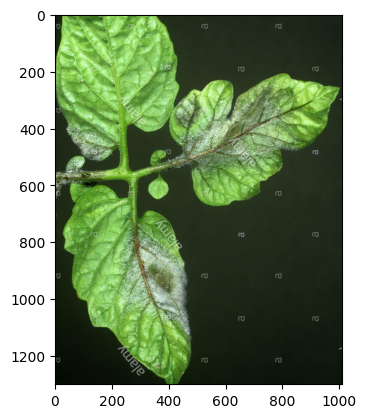

/kaggle/working/legionm/mask/img/00290_2.png
(1011, 1300)


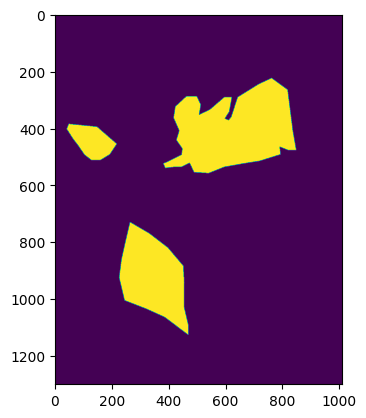

----------------------------------------------------
/kaggle/working/legion/image/img/00256_2.jpg
(600, 411)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


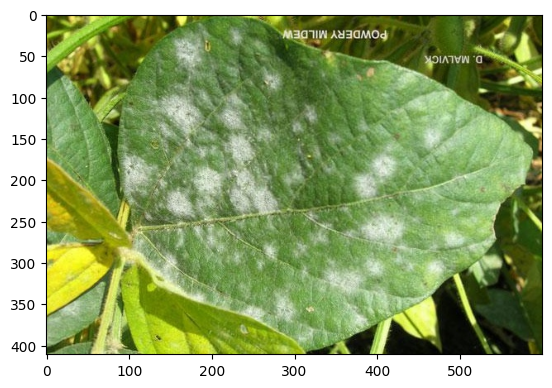

/kaggle/working/legionm/mask/img/00256_2.png
(600, 411)


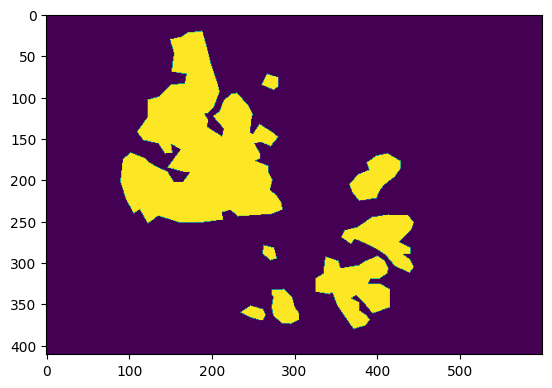

----------------------------------------------------
/kaggle/working/legion/image/img/00025_3.jpg
(600, 398)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


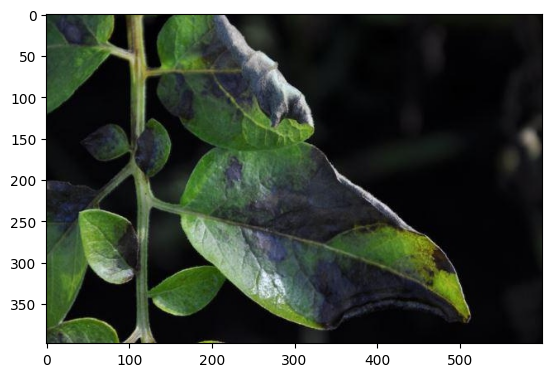

/kaggle/working/legionm/mask/img/00025_3.png
(600, 398)


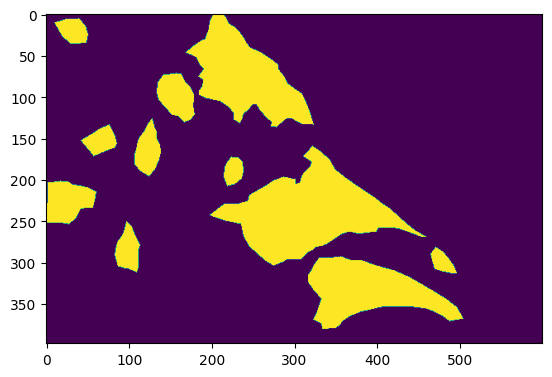

----------------------------------------------------


In [ ]:
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt # Import the missing module

def show_images(loops=1):
    for i in range(loops):
        img_path = os.path.join(train_image_dir, image_files[i])
        source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
        mask_path = os.path.join(train_mask_dir, source_mask_file)
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img) # Now plt is defined and can be used
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(3)

In [ ]:
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt # Import the missing module
import numpy as np # Add this import for numpy
from tqdm import tqdm

seed = 42
np.random.seed = seed # The seed is now properly set after this is added.

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    # Check if the mask file exists before attempting to open
    if os.path.exists(mask_path):
        img = Image.open(img_path)
        img = np.array(img)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[i] = img

        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        Y_train[i] = mask
    else:
        print(f"Warning: Mask file not found for {image_files[i]}. Skipping this image.")


X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img #This should probably be X_test[i]

Resizing training images and masks


Processing images:  33%|███▎      | 767/2356 [03:12<03:37,  7.30it/s]

Processing images:  69%|██████▉   | 1625/2356 [06:17<02:31,  4.81it/s]

Processing images:  96%|█████████▌| 2260/2356 [09:15<00:07, 12.13it/s]

Processing images: 100%|██████████| 2356/2356 [09:35<00:00,  4.09it/s]


Resizing test images


Processing images: 100%|██████████| 588/588 [01:52<00:00,  5.24it/s]


(128, 128, 3)


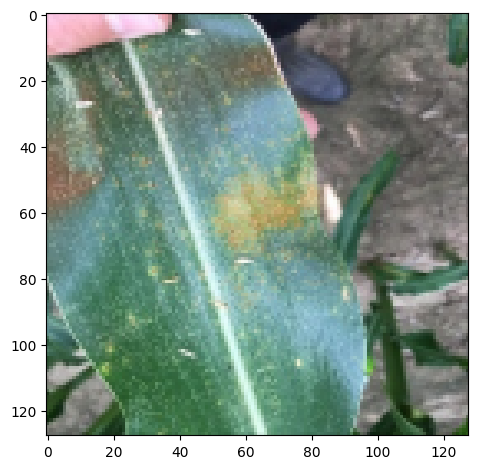

(128, 128, 1)


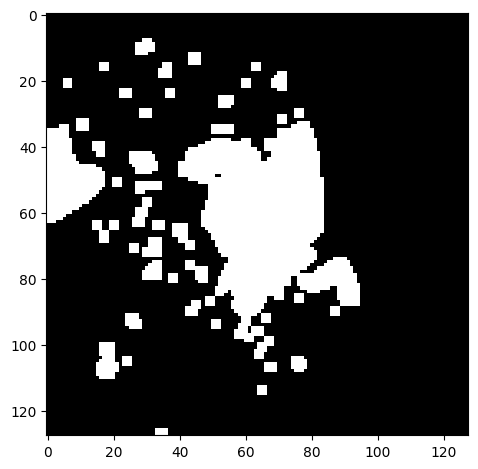

In [ ]:
image_x = 6
imshow(X_train[image_x])
print(X_train[image_x].shape)
plt.show()
imshow(np.squeeze(Y_train[image_x]))
print(Y_train[image_x].shape)
plt.show()

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 16)   │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 16)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7      

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.7664 - loss: 0.5256 - val_accuracy: 0.8189 - val_loss: 0.4186
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8304 - loss: 0.3871 - val_accuracy: 0.8223 - val_loss: 0.3933
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8438 - loss: 0.3641 - val_accuracy: 0.8283 - val_loss: 0.4159
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8454 - loss: 0.3603 - val_accuracy: 0.8408 - val_loss: 0.3679
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.8497 - loss: 0.3460 - val_accuracy: 0.8394 - val_loss: 0.3704
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.8540 - loss: 0.3386 - val_accuracy: 0.8471 - val_loss: 0.3554
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8637 - loss: 0.3186 - val_accuracy: 0.8505 - val_loss: 0.3497
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8652 - loss: 0.3166 - val_accu

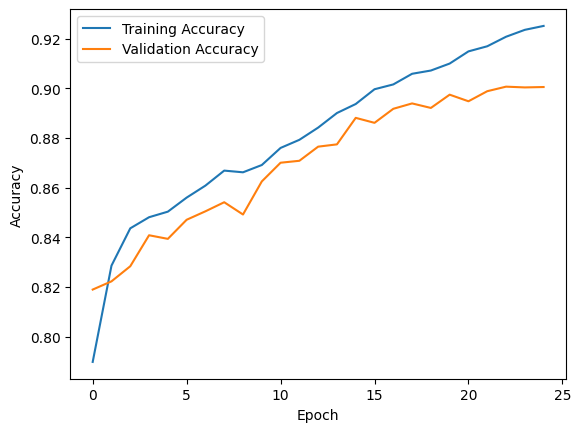

In [ ]:
import tensorflow as tf
checkpointer = tf.keras.callbacks.ModelCheckpoint('Leaf_segmentation.keras', verbose=1, save_best_only=True) # Change the file extension to .keras
# The file extension has been changed to '.keras' to align with the requirements of Keras 3

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=30, callbacks=callbacks)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
unetacc = history.history['accuracy'][-1]

In [ ]:
average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
average_validation_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

# Print average accuracy
print(f'Average Training Accuracy: {average_training_accuracy:.2f}')
print(f'Average Validation Accuracy: {average_validation_accuracy:.2f}')

Average Training Accuracy: 0.88
Average Validation Accuracy: 0.87


Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.9280 - loss: 0.1747 - val_accuracy: 0.9040 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9300 - loss: 0.1709 - val_accuracy: 0.9009 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9250 - loss: 0.1817 - val_accuracy: 0.9077 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.9338 - loss: 0.1627 - val_accuracy: 0.9036 - val_loss: 0.2355 - learning_rate: 0.0010
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9331 - loss: 0.1634 - val_accuracy: 0.9065 - val_loss: 0.2368 - learning_rate: 0.0010


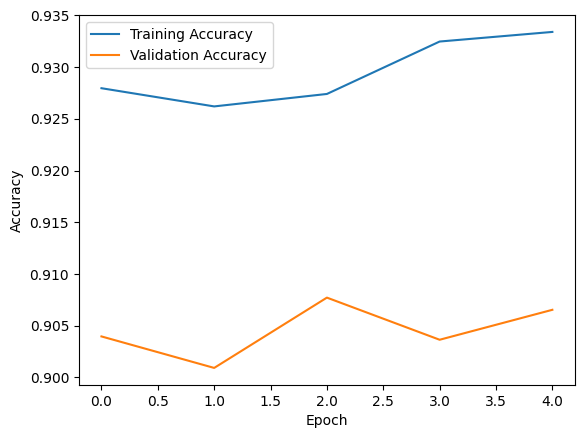

Average Training Accuracy: 92.95%


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming model and data (X_train, Y_train) are defined

# Set up callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('Leaf_segmentation.keras', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Train the model with more epochs and monitor for overfitting
history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    batch_size=16,
    epochs=5,
    callbacks=callbacks
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate and print the average training accuracy
average_accuracy = np.mean(history.history['accuracy']) * 100
print(f'Average Training Accuracy: {average_accuracy:.2f}%')

In [ ]:
average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
average_validation_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

# Print average accuracy
print(f'Average Training Accuracy: {average_training_accuracy:.2f}')
print(f'Average Validation Accuracy: {average_validation_accuracy:.2f}')


Average Training Accuracy: 0.93
Average Validation Accuracy: 0.90


67/67 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


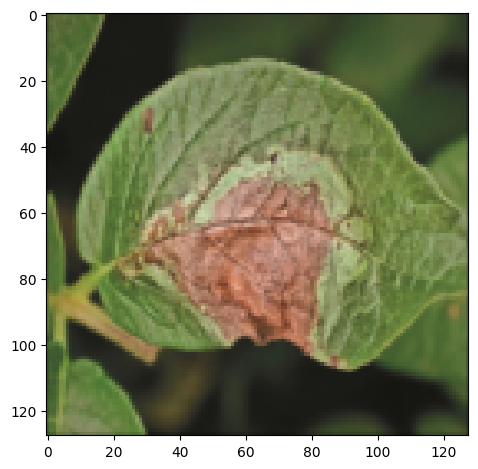

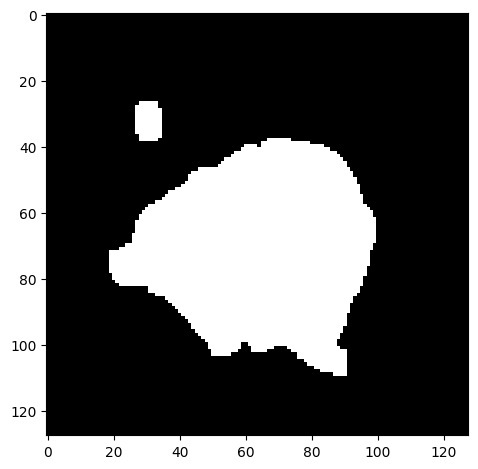

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


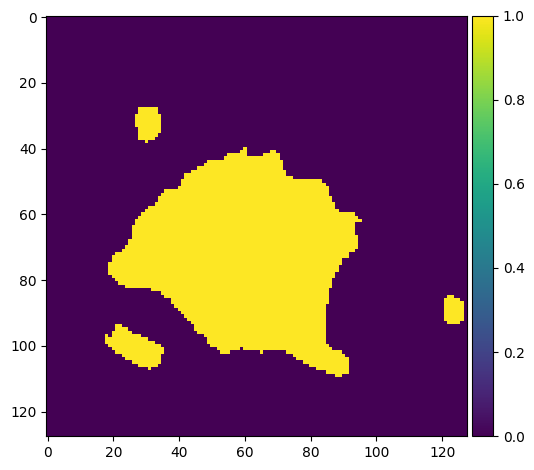

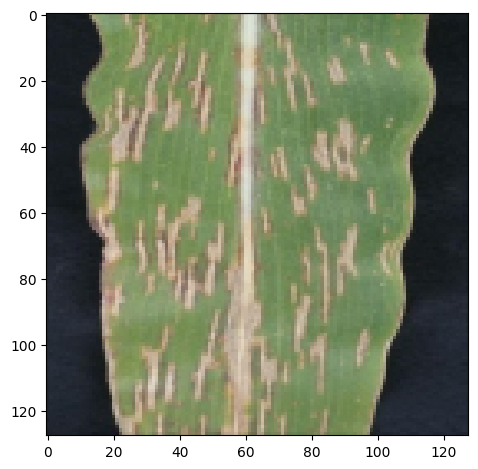

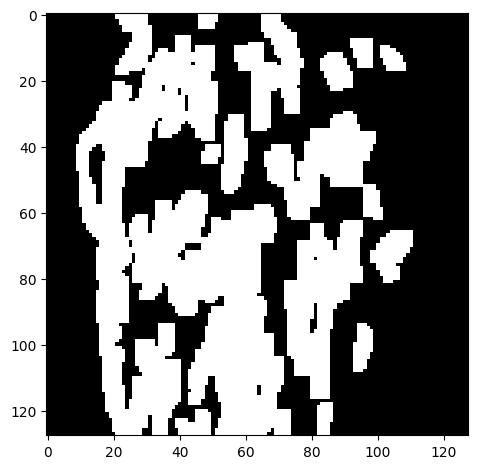

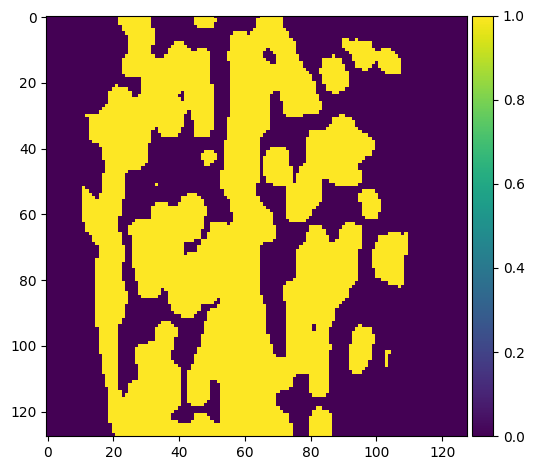

In [ ]:
idx = 5


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

236


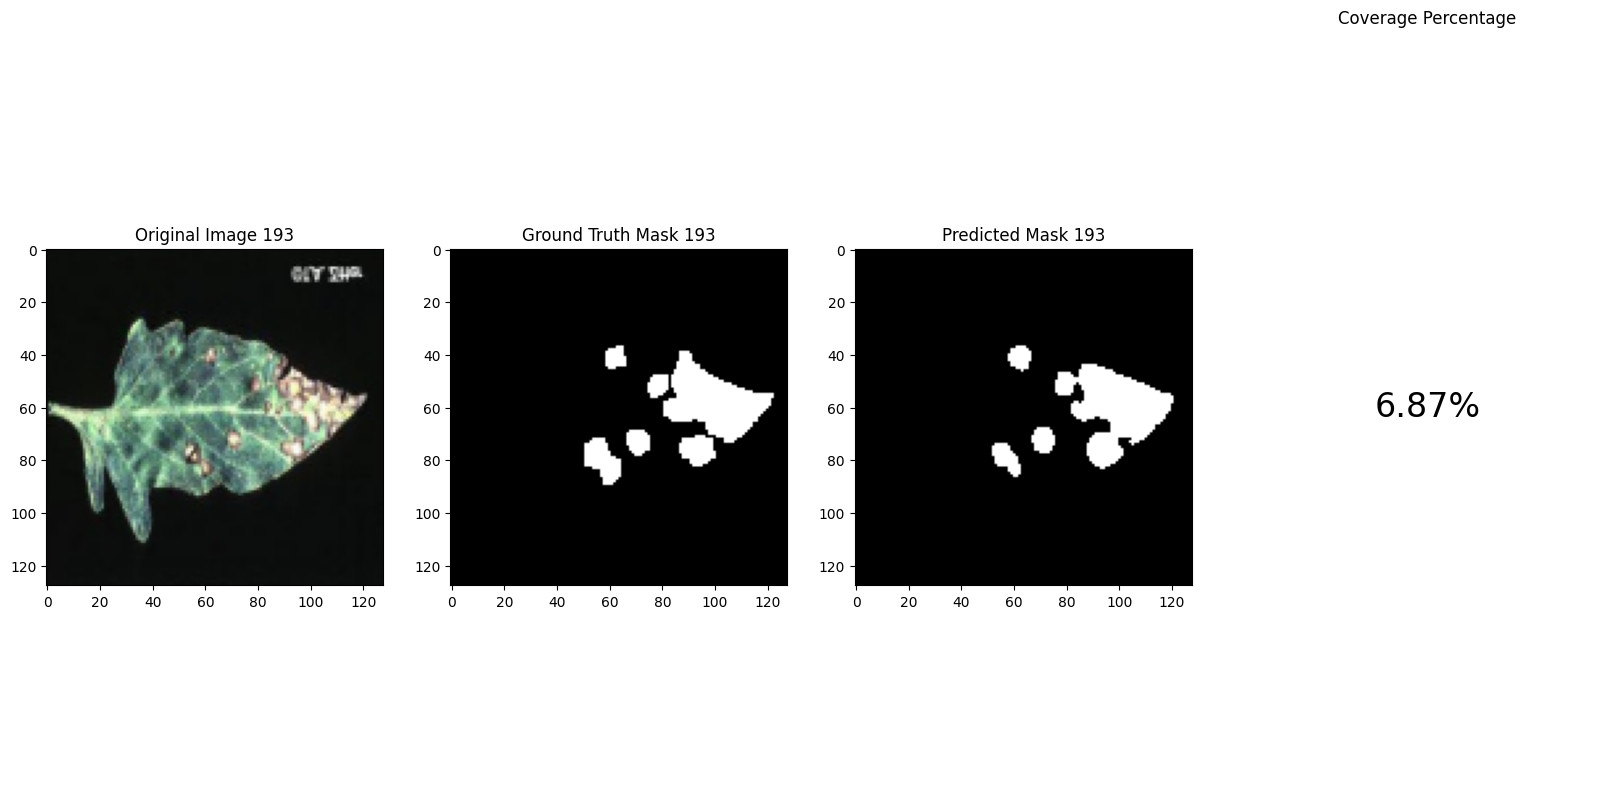

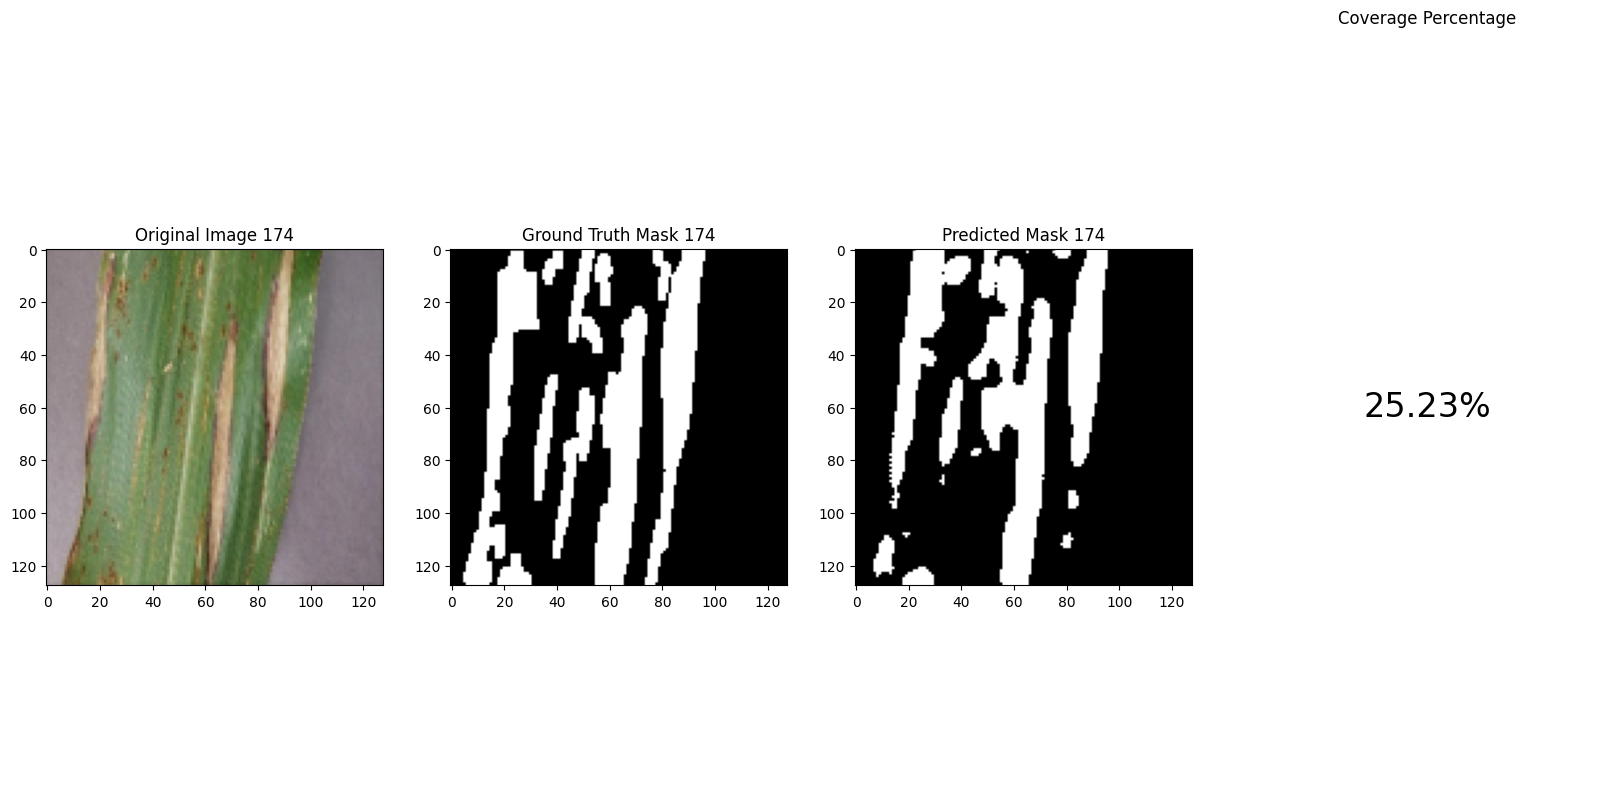

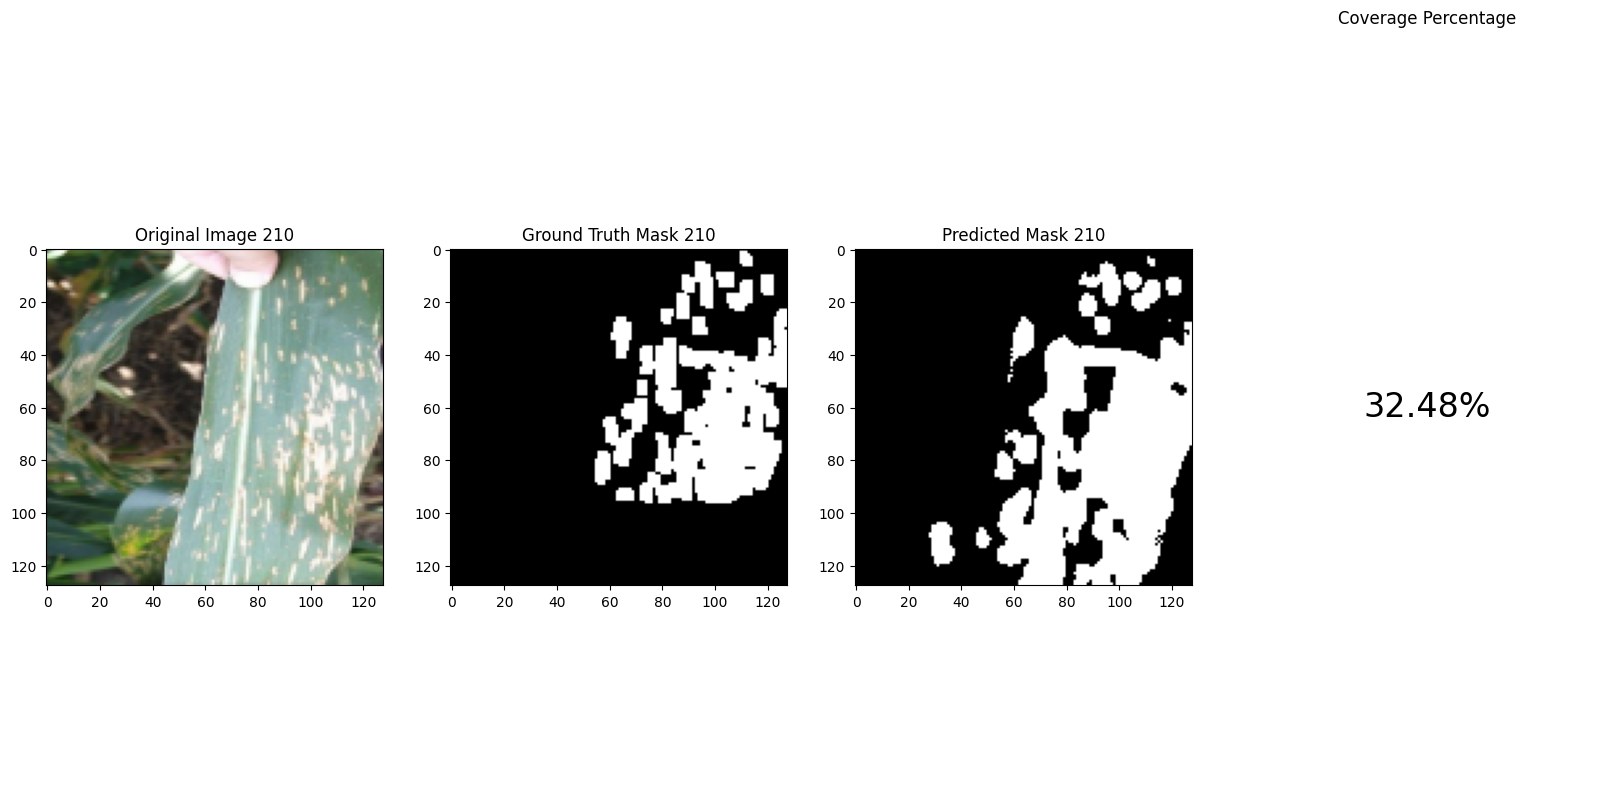

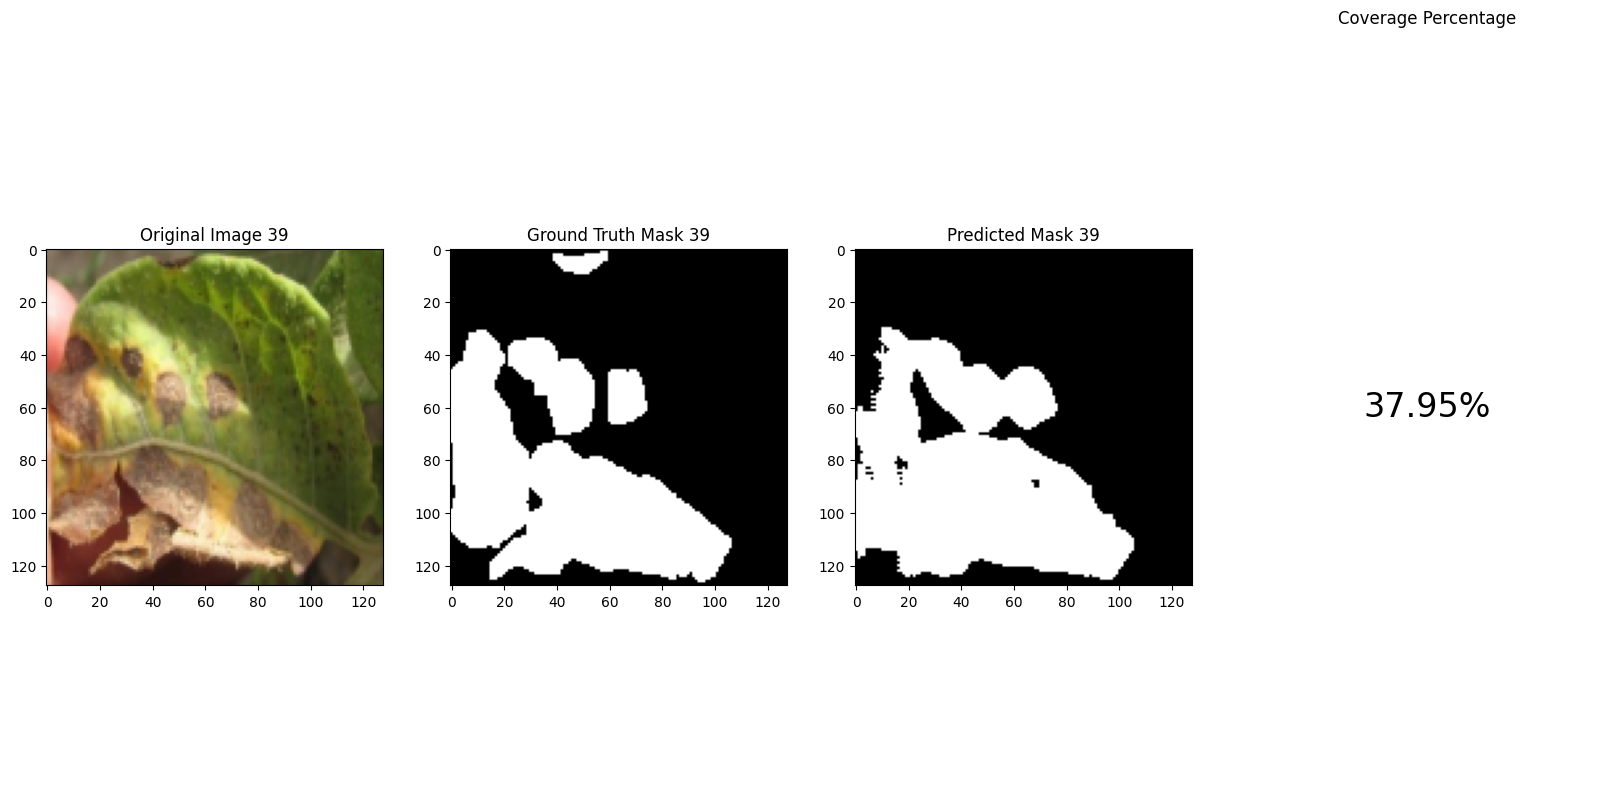

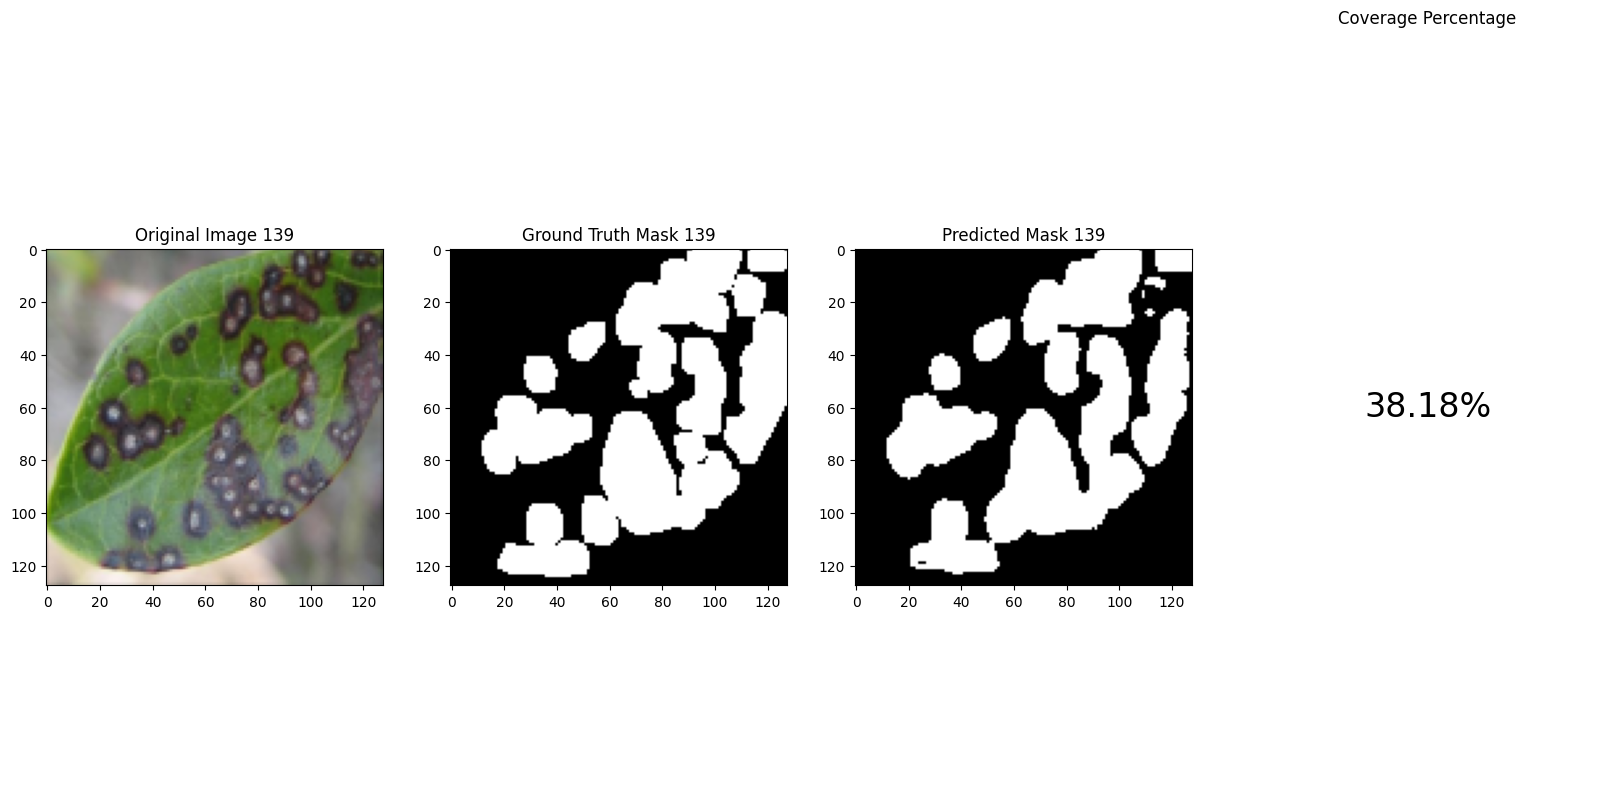

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_disease_coverage(mask):
    # Ensure the mask is a binary mask
    binary_mask = (mask > 0.5).astype(np.uint8)

    # Calculate total number of pixels
    total_pixels = np.prod(binary_mask.shape)

    # Calculate number of disease spot pixels
    disease_pixels = np.sum(binary_mask)

    # Calculate the percentage of the area covered by disease spots
    coverage_percentage = (disease_pixels / total_pixels) * 100

    return coverage_percentage

# Example usage:
# Assume `preds_test_t` is the array of predicted masks
print(len(preds_val_t))
# Calculate disease coverage for a specific test image (e.g., index 0)
test_index = 0
coverage_percentage = calculate_disease_coverage(preds_val_t[test_index])

#print(f"Percentage of area covered by disease spots: {coverage_percentage:.2f}%")

# You can also calculate the coverage for multiple test images
coverage_percentages = [calculate_disease_coverage(mask) for mask in preds_val_t]

# Display the results
# for i, coverage in enumerate(coverage_percentages):
#     print(f"Test Image {i}: {coverage:.2f}%")


import matplotlib.pyplot as plt
from skimage.io import imshow

def display_images_with_coverage(X, Y_true, Y_pred, coverage_percentages):
    num_images = len(coverage_percentages)

    #for i in range(num_images):
    for x in range(5):
        i = random.randint(0, num_images)
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))

        # Display the original image
        ax[0].imshow(X[i])
        ax[0].set_title(f'Original Image {i}')

        # Display the ground truth mask
        ax[1].imshow(np.squeeze(Y_true[i]), cmap='gray')
        ax[1].set_title(f'Ground Truth Mask {i}')

        # Display the predicted mask
        ax[2].imshow(np.squeeze(Y_pred[i]), cmap='gray')
        ax[2].set_title(f'Predicted Mask {i}')

        # Display the coverage percentage
        ax[3].text(0.5, 0.5, f'{coverage_percentages[i]:.2f}%', fontsize=24, ha='center')
        ax[3].set_title('Coverage Percentage')
        ax[3].axis('off')

        plt.show()

# Calculate disease coverage for all test images
coverage_percentages = [calculate_disease_coverage(mask) for mask in preds_val_t]

# Display the images along with coverage percentages
display_images_with_coverage(X_train[int(X_train.shape[0]*0.9):], Y_train[int(Y_train.shape[0] * 0.9):], preds_val_t, coverage_percentages)